In [1]:
# Basic Imports
import os, warnings, openpyxl
import nltk
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Data preparation and text-preprocessing
import inflect, contractions, re, string, unicodedata, spacy
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
# from nltk.stem import WordNetLemmatizerd

data_dir = os.path.join(os.getcwd(), "Dataset")

In [2]:
nltk.download('all', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Training Datasets

In [5]:
#3 Datasets
tweets_df = pd.read_csv(os.path.join(data_dir,'Tweets_Emotions.csv'))
emotions_df = pd.read_csv(os.path.join(data_dir, 'Emotions_from_text.csv'))
sentiment_df = pd.read_csv(os.path.join(data_dir,"Sentiment_140.csv"), names=["sentiment", "id", 'date',"query", "user", "content"])

In [9]:
#Check for null values
print("Tweets dataset\n", tweets_df.isnull().sum(),"\n")
print("Emotions dataset\n", emotions_df.isnull().sum(),"\n")
print("Sentiment\n", sentiment_df.isnull().sum(),"\n")

Tweets dataset
 tweet_id     0
sentiment    0
content      0
dtype: int64 

Emotions dataset
 Text       0
Emotion    0
dtype: int64 

Sentiment
 sentiment    0
id           0
date         0
query        0
user         0
content      0
dtype: int64 



In [12]:
print(tweets_df["sentiment"].unique(),"\n")
print(emotions_df["Emotion"].unique(),"\n")
def sentiments_df3(val):
    if val==0:
        return 'negative'
    elif val == 2:
        return 'neutral'
    elif val==4:
        return 'positive'

sentiment_df["sentiment"] = sentiment_df["sentiment"].apply(sentiments_df3)
print(sentiment_df["sentiment"].unique(),"\n")

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger'] 

['sadness' 'anger' 'love' 'surprise' 'fear' 'happy'] 

['positive' 'negative' 'neutral'] 



In [15]:
#Removing unwanted columns
tweets_df.drop(["tweet_id"], axis=1, inplace=True)
tweets_df.drop(tweets_df.loc[tweets_df['sentiment']=='surprise'].index, inplace=True)
emotions_df.drop(emotions_df.loc[emotions_df['Emotion']=='surprise'].index, inplace=True)
sentiment_df.drop(["id", "date", "query", "user"], axis=1, inplace=True)

#Standardizing the sentiment column naming
emotions_df.rename(columns={"Emotion":"sentiment"}, inplace=True)
emotions_df.rename(columns={"Text":"content"}, inplace=True)

In [16]:
#Combining all the datasets
combined_df = pd.concat([tweets_df, emotions_df, sentiment_df], ignore_index=True)

In [18]:
combined_df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [19]:
#Classify the sentiment into positive and negative
def generalise_sentiment(text):
    if text=='love' or text=='positive' or text=='enthusiasm' or text =='surprise' or text=='fun 'or text=='happy' or text == 'happiness' or text=='relief':
        return 'positive'
    else:
        return 'negative'

combined_df["sentiment"] = combined_df["sentiment"].apply(generalise_sentiment)
combined_df["sentiment"].unique()

array(['negative', 'positive'], dtype=object)

In [20]:
combined_df["sentiment"].value_counts()

negative    38703
positive    20188
Name: sentiment, dtype: int64

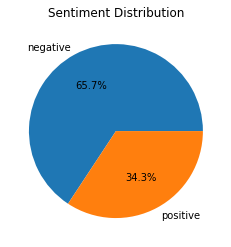

In [29]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title("Sentiment Distribution")
plt.pie(combined_df["sentiment"].value_counts(), labels=combined_df["sentiment"].unique(), autopct='%1.1f%%')
plt.show()

In [30]:
combined_df["char_len"] = combined_df["content"].apply(lambda x: len(x))
combined_df["token_len"] = combined_df["content"].apply(lambda x: len(x.split(" ")))

c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


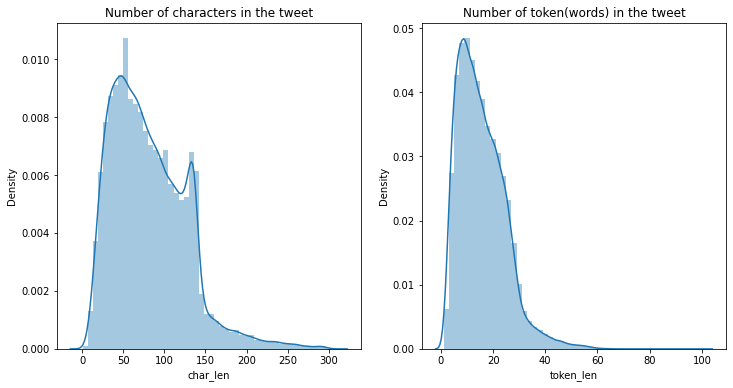

In [35]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(combined_df['char_len'], ax=ax1)
sns.distplot(combined_df['token_len'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

In [37]:
mean_df = combined_df.groupby("sentiment").agg({"char_len":"mean", "token_len":"mean"})

C:\Users\ezeki\AppData\Local\Temp\ipykernel_22832\2646245128.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(mean_df.index, rotation = 45)
C:\Users\ezeki\AppData\Local\Temp\ipykernel_22832\2646245128.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(mean_df.index, rotation = 45)


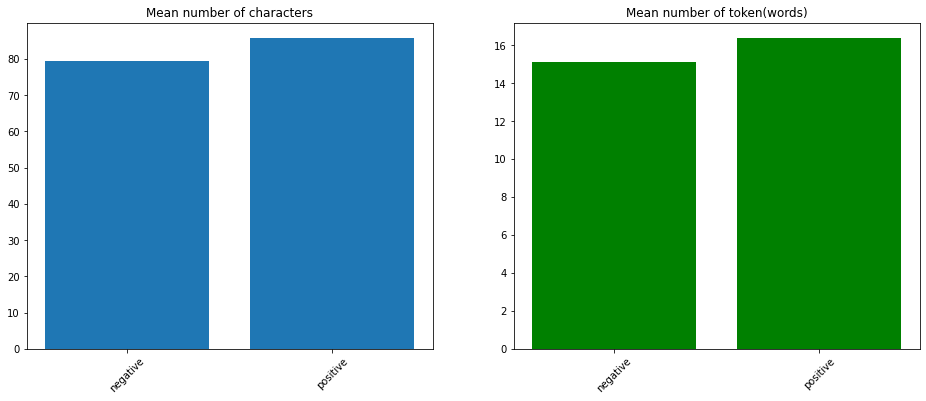

In [39]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(mean_df.index, mean_df['char_len'])
ax2.bar(mean_df.index, mean_df['token_len'], color='green')
ax1.set_title('Mean number of characters')
ax2.set_title('Mean number of token(words)')
ax1.set_xticklabels(mean_df.index, rotation = 45)
ax2.set_xticklabels(mean_df.index, rotation = 45)
plt.show()

## Text Pre-Processing Function

In [40]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)

    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]

    # return processed df
    return df

In [42]:
# Running text preprocessing on the combined dataset
print("Before Text Preprocessing")
display(combined_df.sample(5)[['content']])

processed_df = text_preprocessing_platform(combined_df, 'content', remove_stopwords=False)

print("After Text Preprocessing")
display(processed_df.sample(5)[['content']])

Before Text Preprocessing


,content
52104,i went by on wednesday feeling slightly regret...
690,@textdrivebys i dont even have a WII! b likes ...
33683,@mini_ritz thnx sweetie how r u this evening? xo
17853,@MariaV_ST vaca!! buuu sigo en el work
45122,i feel fond toward though they may not realize it


c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


After Text Preprocessing


,content
365,count hours lose sunshine weekend
33921,lovetogivenuts yet save page read travel
39825,say feel like verge messy
46053,feel weird yuuki talk girls
29285,eat salad rember comment new myspace picture plz


In [46]:
# Save the processed dataframe
processed_df.to_csv(os.path.join(data_dir,"processed_df.csv"), index=False)

In [47]:
processed_df.sample(5)

,sentiment,content,char_len,token_len
50265,positive,feel privilege experience lovely place able vi...,115,21
20729,positive,nirajgoa oh love vodafone series ads best pict...,94,16
30208,positive,sicilyyoder yet eat couple love reeces hard ge...,120,27
40945,positive,uneasy feel stupidly talented eagle mainly goo...,147,26
15422,positive,johnreppion awww let would better next 30th xd,84,18


### Can read processed text directly into dataframe

In [48]:
processed_df = pd.read_csv(os.path.join(data_dir,"processed_df.csv"))

In [49]:
processed_df.sample(5)

,sentiment,content,char_len,token_len
53826,negative,feel greedy right,31,6
30832,negative,lindentreephoto unless mean two hours week use...,103,19
2569,negative,dean_b drive home think break laws tooooooo ma...,123,26
12388,negative,another two hours work ugh go slow sore,63,14
20063,negative,challiyan wait till england wc t20,35,6
